# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy
import glob
import re
import yaml
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

import scipy.stats as stats

filepaths = yaml.safe_load(open("../../../config/filepaths.yaml"))

import sys
sys.path.append(filepaths['utils'])
from data import *
from liwc_utils import *
from analisys import *

In [2]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

In [5]:
DATASET = 'youtube' # 'coraal-buckeye' | 'twitter' | 'youtube' | 'interview'

data = load_dataset(DATASET)
data.head(1)

,text,perspective_score,flair_score,textblob_score,vader_score,has_swearing,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,file,group
0,hila won't turn over my classic reviews,0.098707,0.988608,0.351852,0.0,False,0.000843,0.000663,0.007379,bzM2IwhtqQo,White Man


In [6]:
#Numero de amostras de cada tipo
data.drop_duplicates('file').groupby('group').count()['text']

group
Black Man      105
Black Woman     45
White Man      313
White Woman    171
Name: text, dtype: int64

# Reading and processing data

In [7]:
# Faz copia dos dados e remove qualquer caracter que não seja textual ou apóstrofo
df = data.copy()
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d'\s]+",'',x))

In [8]:
df.loc[df.group.isin(['Black Woman', 'Black Man']),'group'] = 'AA'
df.loc[df.group.isin(['White Woman', 'White Man']),'group'] = 'WH'
df.drop_duplicates('file').groupby('group').count()['text']

group
AA    150
WH    484
Name: text, dtype: int64

In [9]:
# executes a join in column text grouped by file, this will join all the texts and keep group info
text_df = df.groupby('file',as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'group': lambda x: x.iloc[0]
})
text_df.head(3)

,file,text,group
0,-3jWCt_ETXA,not gonna lie to you guys i knew nothing about...,WH
1,-66g38EP0pI,hey i'm an angel and today we're gonna talk ab...,AA
2,-7YPgSlV50o,what's up everyone welcome back to another epi...,AA


In [10]:
# carrega o dicionário e inicializa a classe do LIWC
liwc_parser = Liwc(filepaths['liwc_dict']) 

#aplica do liwc
text_df['liwc_count'] = text_df['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) 
text_df = text_df.reset_index(drop=True)
text_df.head(3)

,file,text,group,liwc_count
0,-3jWCt_ETXA,not gonna lie to you guys i knew nothing about...,WH,"{'function': 576, 'negate': 24, 'cogproc': 99,..."
1,-66g38EP0pI,hey i'm an angel and today we're gonna talk ab...,AA,"{'social': 119, 'informal': 22, 'function': 59..."
2,-7YPgSlV50o,what's up everyone welcome back to another epi...,AA,"{'function': 3135, 'pronoun': 982, 'ipron': 44..."


---

# Processing data with LIWC

In [11]:
# create a new dataset where the dicts inside liwc_cont are expanded in columns
liwc_df = pd.concat([text_df.drop(['liwc_count'], axis=1), text_df['liwc_count'].apply(pd.Series)], axis=1)
liwc_df = liwc_df.fillna(0)

#normalizing 
liwc_df_norm = (liwc_df[liwc_parser.categories.values()].T * ( 1 / liwc_df[liwc_parser.categories.values()].sum(axis=1) )).T
liwc_df_norm.reset_index(drop=True,inplace=True)

liwc_df_norm['group'] = text_df['group']
liwc_df_norm = liwc_df_norm.fillna(0)
liwc_df_norm.head(3)

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,group
0,0.181417,0.068346,0.034016,0.011339,0.002835,0.010394,0.009134,0.000315,0.034331,0.019528,...,0.001260,0.000945,0.000630,0.008819,0.000000,0.002205,0.002520,0.003150,0.000000,WH
1,0.180243,0.054103,0.027660,0.011550,0.004863,0.007295,0.001824,0.002128,0.026444,0.024924,...,0.000000,0.000608,0.005167,0.006687,0.000608,0.001520,0.001520,0.002432,0.000304,AA
2,0.190554,0.059689,0.032823,0.012339,0.001641,0.012643,0.001823,0.004376,0.026866,0.022550,...,0.000912,0.000182,0.000000,0.003465,0.000000,0.001216,0.000365,0.001945,0.000000,AA


---

## Kruscal-Wallis Test

In [12]:
experiments = []
old_experiments = []

for feature in liwc_parser.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='AA'][feature],
        liwc_df_norm[liwc_df_norm.group=='WH'][feature]
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [13]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

28


,feature,statistic,pvalue
2,ppron,91.740566,9.881826e-22
16,adj,80.611601,2.747418e-19
1,pronoun,80.510857,2.891121e-19
20,quant,75.053659,4.580932e-18
67,informal,74.247050,6.892776e-18
15,verb,61.416017,4.620366e-15
5,you,46.760050,8.023243e-12
69,netspeak,37.113065,1.114743e-09
9,article,36.910386,1.236853e-09
13,conj,36.867004,1.264683e-09


# individual categories analisys

### calculating liwc per sentence

In [14]:
scores_liwc = df.copy()

scores_liwc['liwc_count'] = scores_liwc['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
scores_liwc['len'] = scores_liwc.text.str.split(' ').str.len()
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc = pd.concat([scores_liwc.drop(['liwc_count'], axis=1), scores_liwc['liwc_count'].apply(pd.Series)], axis=1)
scores_liwc = scores_liwc.fillna(0)
scores_liwc.head(1)

,sentence_id,text,perspective_score,flair_score,textblob_score,vader_score,has_swearing,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,...,body,sexual,female,relig,home,anx,assent,family,swear,filler
0,0,hila won't turn over my classic reviews,0.098707,0.988608,0.351852,0.0,False,0.000843,0.000663,0.007379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KS test and bonferroni correction - For liwc categories scored

In [15]:
liwc_toxicity_experiments = []
for score in [col for col in scores_liwc.columns if 'score' in col]:
    for feature in liwc_parser.categories.values():
        if (len(scores_liwc[scores_liwc[feature]==0]) == 0 
                and len(scores_liwc[scores_liwc[feature]>0] == 0)):
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': np.nan,
                'pvalue': np.nan,
                'score': score
            })
        else:
            result = stats.ks_2samp(
                scores_liwc[scores_liwc[feature]==0][score],
                scores_liwc[scores_liwc[feature]>0][score]
            )
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': result[0],
                'pvalue': result[1],
                'score': score
            })

liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments.sort_values('pvalue')

,feature,statistic,pvalue,score
59,space,0.183963,0.000000,perspective_score
194,drives,0.201716,0.000000,textblob_score
196,achiev,0.244914,0.000000,textblob_score
390,anger,0.354219,0.000000,detoxify_unbiased_score
388,negemo,0.247644,0.000000,detoxify_unbiased_score
...,...,...,...,...
369,we,0.015242,0.253296,detoxify_unbiased_score
218,filler,0.054745,0.270934,textblob_score
364,filler,0.049618,0.384027,detoxify_original_score
291,filler,0.048660,0.408071,vader_score


In [16]:
#seleciona as categorias em que todos scores são estatisticamente diferentes (p-value < 0.01)
#TODO: Bonferroni correction

relevant_categories_by_toxicity = liwc_toxicity_experiments.iloc[
    liwc_toxicity_experiments.groupby('feature').agg({
        'pvalue': lambda x: x.idxmax(),
    })['pvalue']
].query('pvalue < 0.01').feature.unique()

relevant_categories_by_toxicity

array(['adj', 'adverb', 'affect', 'affiliation', 'anger', 'anx',
       'article', 'auxverb', 'bio', 'body', 'cause', 'certain', 'cogproc',
       'compare', 'conj', 'death', 'drives', 'family', 'feel', 'female',
       'focusfuture', 'focuspast', 'focuspresent', 'friend', 'function',
       'health', 'hear', 'i', 'informal', 'interrog', 'ipron', 'leisure',
       'male', 'motion', 'negate', 'negemo', 'netspeak', 'nonflu',
       'number', 'percept', 'posemo', 'power', 'ppron', 'prep', 'pronoun',
       'quant', 'relativ', 'risk', 'sad', 'see', 'sexual', 'shehe',
       'social', 'space', 'swear', 'tentat', 'they', 'time', 'verb',
       'you'], dtype=object)

---
# Associating categories frequencies with toxicity

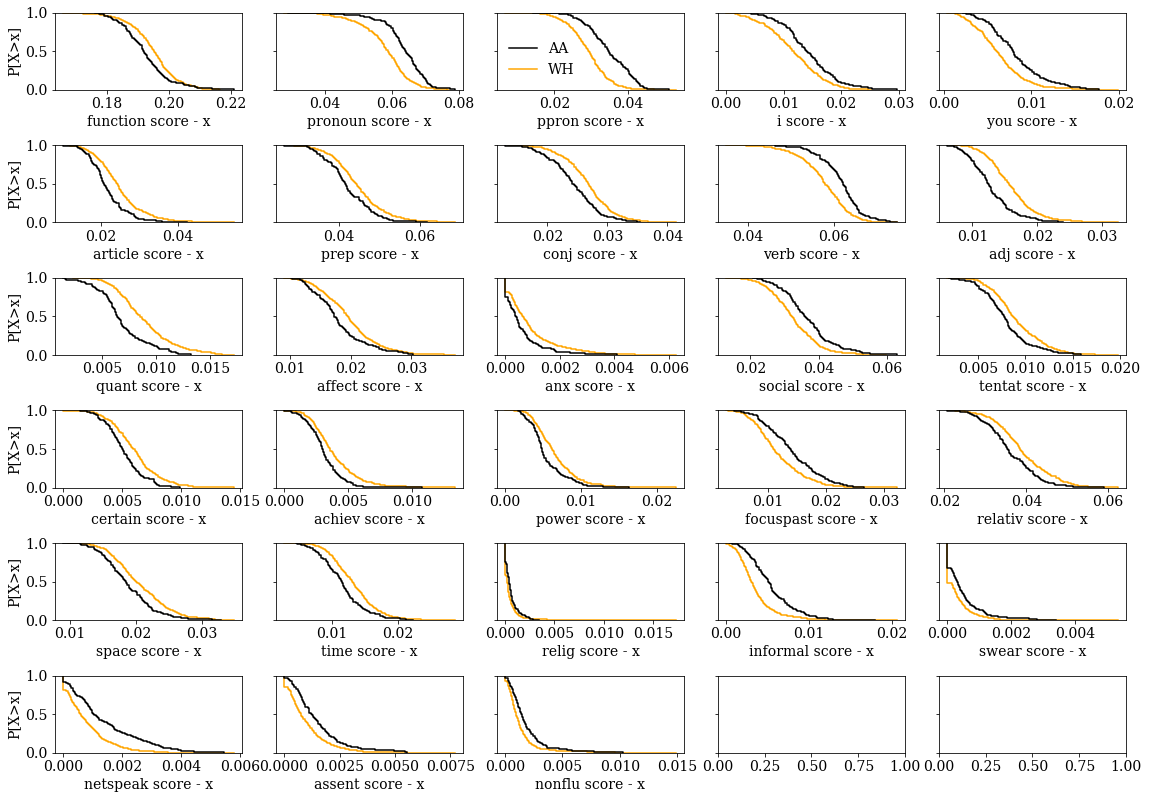

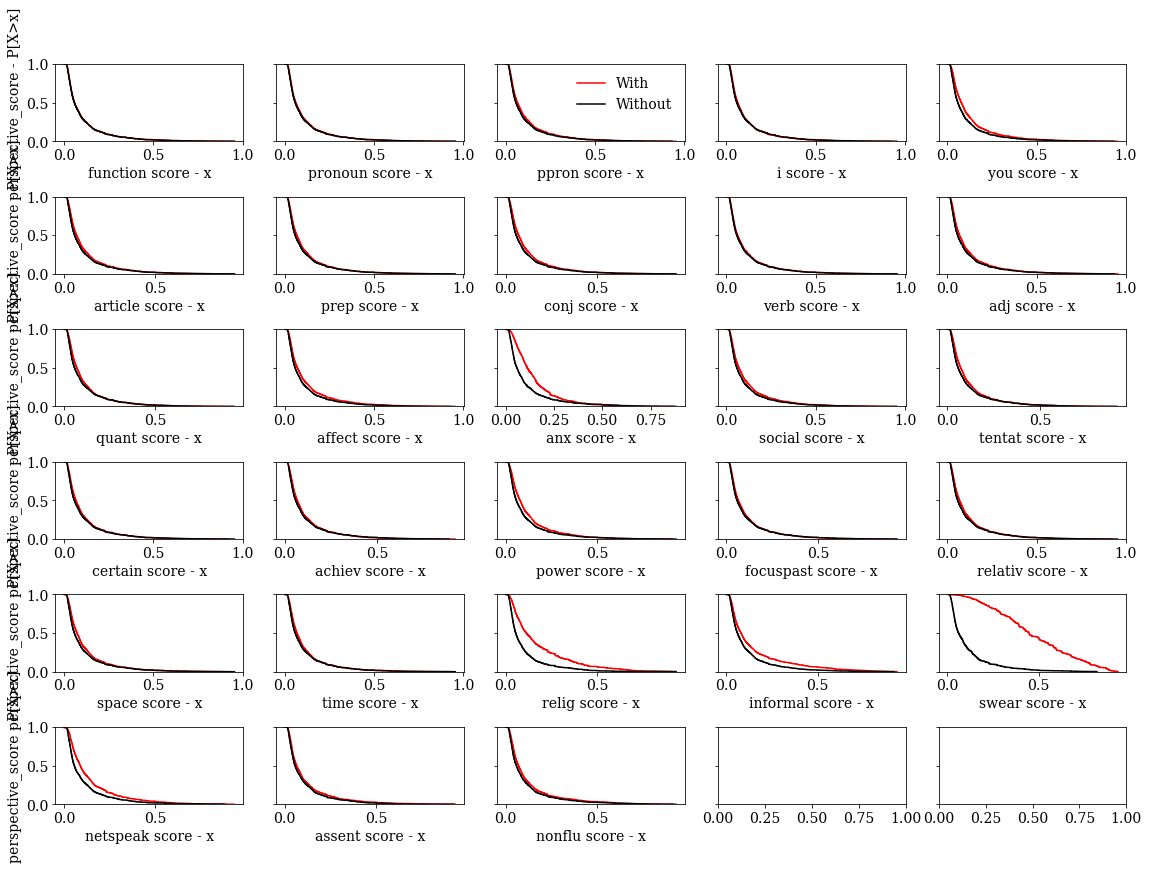

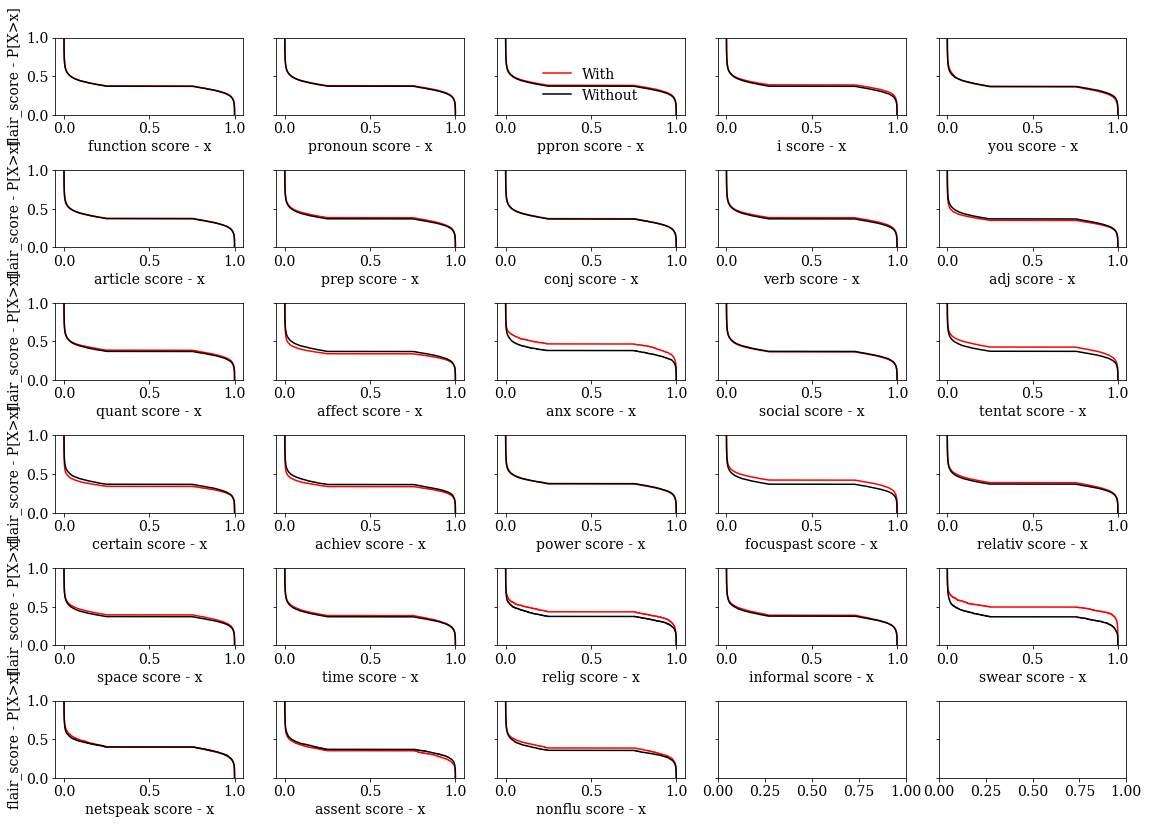

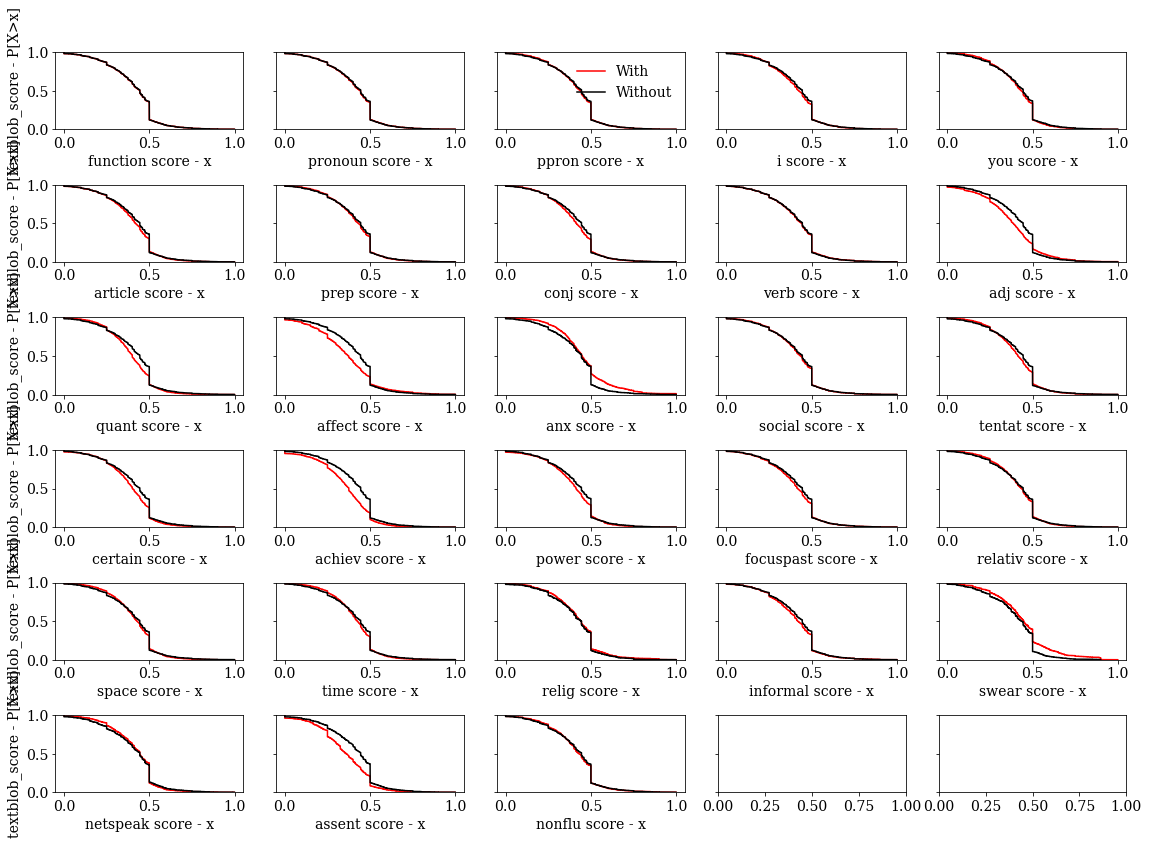

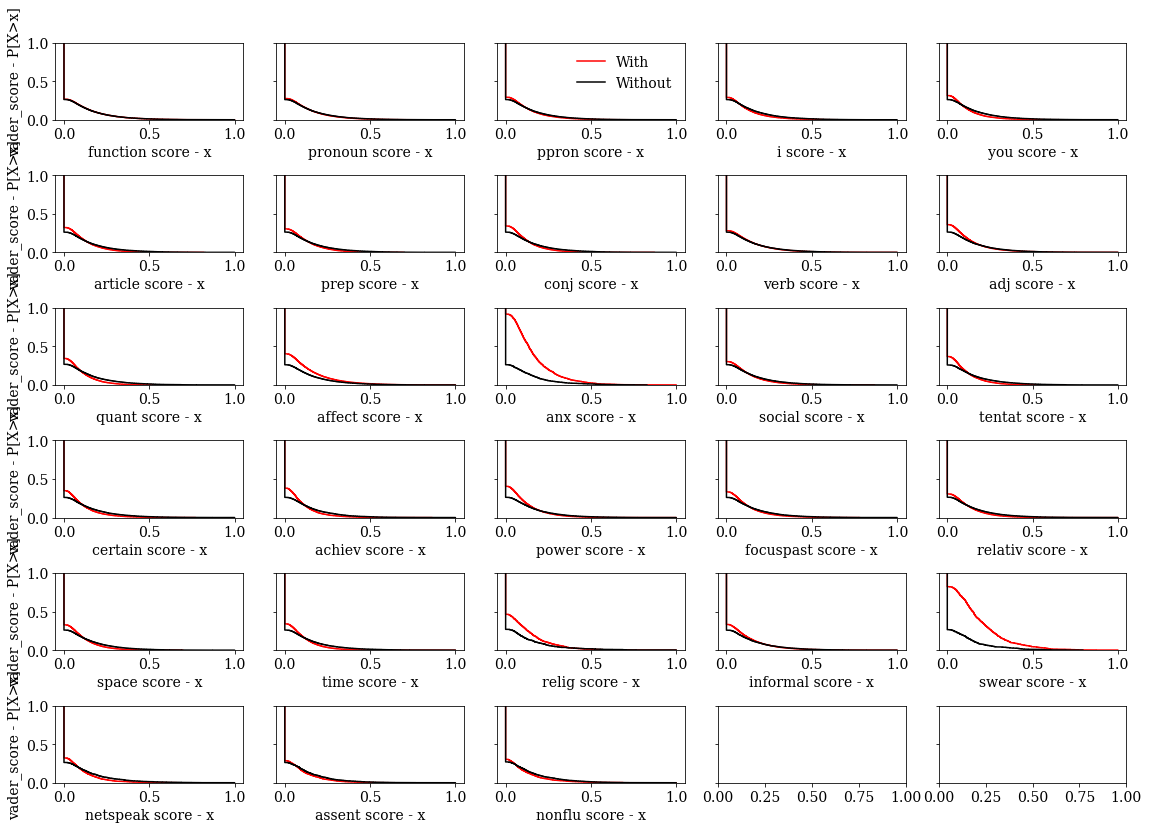

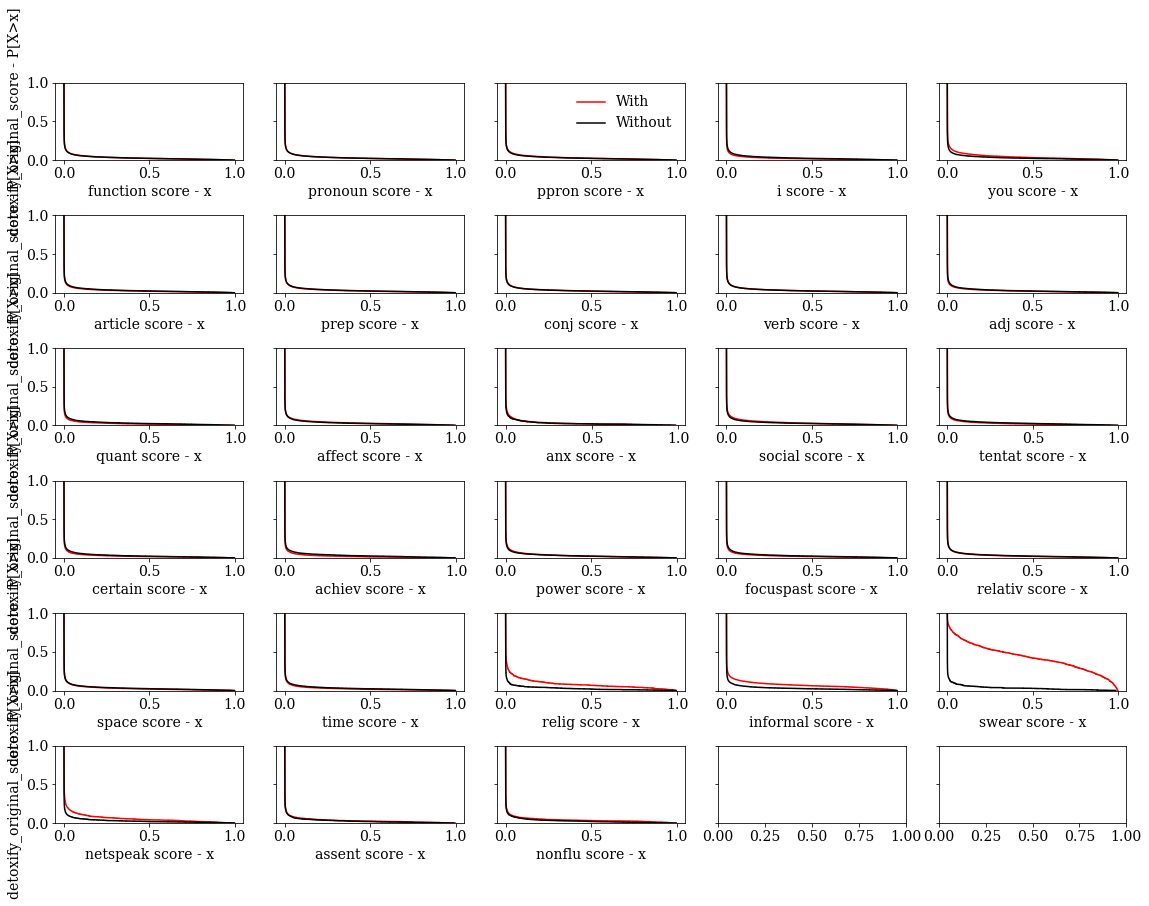

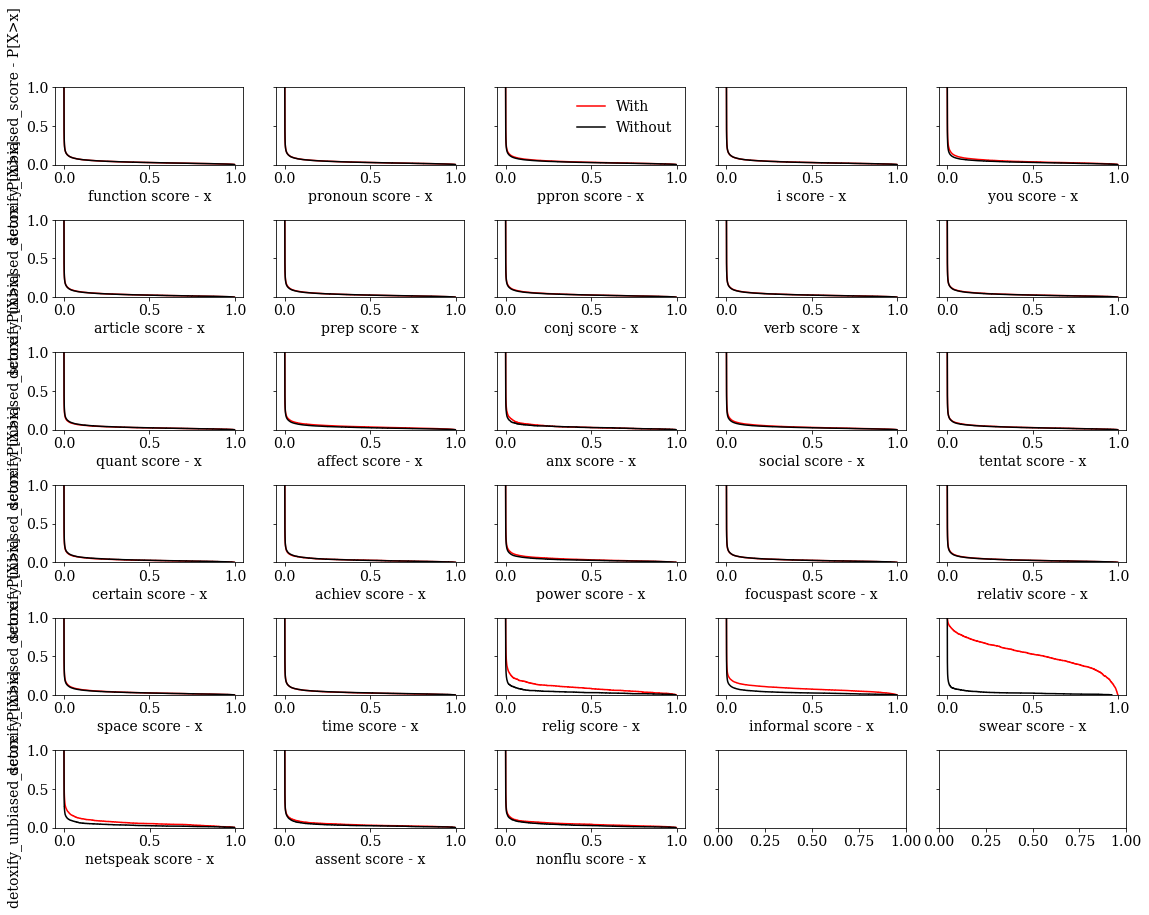

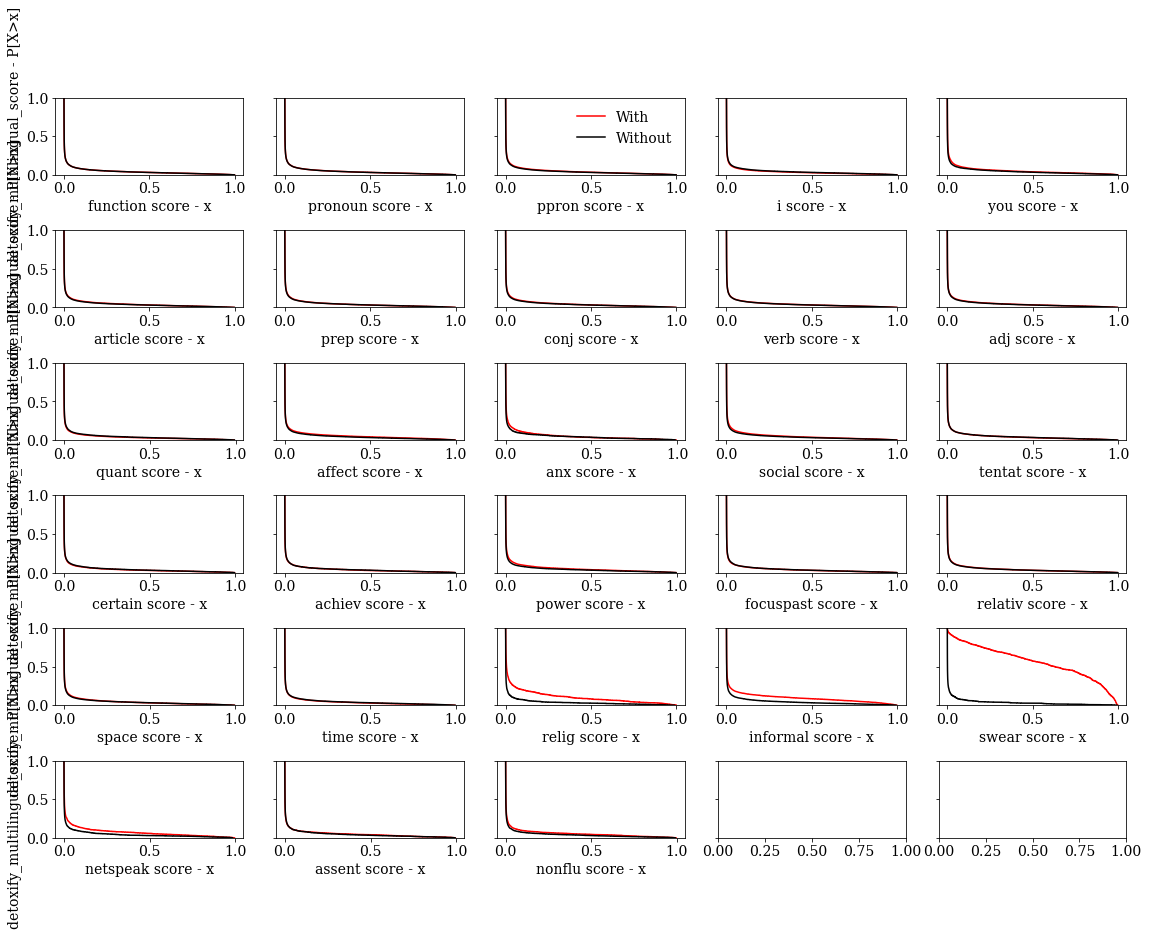

In [19]:
# analisa i a i de 5 em 5 categorias as categorias que são estatisticamente diferentes obtidas 
# na analise anterior e plota suas frequencias e seus scores

# i += 5
# ploting_vars = ['informal', 'you', 'verb', 'netspeak', 'social', 'power', 'leisure', 'swear', 'anx', 'affect', 'bio', 'sad', 'male', 'they', 'friend', 'family', 'female', 'shehe', 'health',]#list(experiments[experiments.feature.isin(relevant_categories_by_toxicity)].sort_values('pvalue').iloc[i:i+5].feature)

ploting_vars = list(experiments[idx].feature)

plot_figsize = (16,11.2)
plot_liwc_features(
    liwc_df_norm, 
    ploting_vars=ploting_vars, 
    hue_order=['AA','WH'],
    legend_labels = ['AA', 'WH'],
    palette=['black','orange'], 
    plot_figsize=plot_figsize
)
plot_liwc_scored(
    scores_liwc,

    ploting_vars=ploting_vars, 
    scores=scores_liwc.columns,
    comparative_behaviour='same_sz_sample',
    plot_figsize=plot_figsize
)

# plot_liwc_features(liwc_df_norm,ploting_vars,plot_figsize=(16,10))
# plot_liwc_scored(scores_liwc,ploting_vars,scores=scores_liwc.columns,comparative_behaviour=.5,plot_figsize=(16,10))

# categorias interessantes: informal, you, netspeak, social, power, leisure, swear, anx, affect, bio, sad, male, they, friend, shehe, health

---

# Avg. words per video

In [18]:
scores_liwc.groupby(['file','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
AA,1825.506667
WH,1503.324380
